# OAK vs. Additive 

We compare the OAK model with the additive model on the various regression datasets.

In [1]:
import os

project_root = os.getcwd()
project_root

'c:\\Users\\User\\Documents\\MEng-Oak\\MEng-Project'

In [2]:
# Cell 1: Imports and Setup

import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
from scipy import io
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import gpflow
from gpflow.kernels import RBF
from gpflow.optimizers import Scipy
from gpflow.inducing_variables import InducingPoints

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set matplotlib and seaborn styles
plt.style.use('ggplot')
sns.set_theme(style="whitegrid", font_scale=1.2) # changed .set to .set_theme

# Add the project root to Python's path to import custom modules
project_root = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(project_root)

# Import custom modules
from oak.model_utils import oak_model, save_model
from oak.utils import get_model_sufficient_statistics, get_prediction_component

# any changes to custom modules are reloaded
# import importlib
# importlib.reload(oak.model_utils)
# importlib.reload(oak.utils)


In [3]:
# Cell 2: Define AdditiveKernel Class

import gpflow
from gpflow.kernels import Kernel
from typing import List, Optional
import itertools
import tensorflow as tf

class AdditiveKernel(Kernel):
    """
    Additive kernel with expansions up to order R.
    This mimics the structure of OAKKernel but without measure-based orthogonal corrections.
    Specifically:
      K_add(X, X2) = sum_{r=0}^R (sigma_r^2 * E_r),
    where E_r is the sum-of-products of exactly r distinct dimension-wise base kernels.
    """
    def __init__(
        self,
        base_kernels: Optional[List[gpflow.kernels.Kernel]] = None,
        num_dims: int = 1,
        max_interaction_depth: int = 1,
        share_var_across_orders: bool = True,
        name: Optional[str] = None,
    ):
        """
        :param base_kernels: A list of dimension-wise kernels (length = num_dims).
                             Typically, use gpflow.kernels.RBF with separate lengthscales per dimension.
                             If None, defaults to RBF kernels for each dimension.
        :param num_dims: Number of input dimensions.
        :param max_interaction_depth: Maximum order of interactions R.
        :param share_var_across_orders: If True, share a single amplitude for each order r.
        :param name: Name of the kernel.
        """
        super().__init__(active_dims=range(num_dims), name=name)
        self.num_dims = num_dims
        self.max_interaction_depth = max_interaction_depth
        self.share_var_across_orders = share_var_across_orders

        # Initialize base kernels
        if base_kernels is None:
            base_kernels = [
                RBF(active_dims=[d], lengthscales=1.0, variance=1.0) 
                for d in range(num_dims)
            ]
        elif len(base_kernels) != num_dims:
            raise ValueError("Length of base_kernels must be equal to num_dims.")
        self.kernels = base_kernels

        # Initialize variance parameters for each interaction order
        if self.share_var_across_orders:
            # Separate variance parameter for each order r=0..R
            self.variances = [
                gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
                for _ in range(max_interaction_depth + 1)
            ]
        else:
            # Single variance parameter for the constant term; interactions unscaled
            self.variances = [
                gpflow.Parameter(1.0, transform=gpflow.utilities.positive())
            ]

    def compute_additive_terms(self, kernel_matrices: List[tf.Tensor]) -> List[tf.Tensor]:
        """
        Compute additive terms up to order R using elementary symmetric polynomials.

        :param kernel_matrices: List of TensorFlow tensors representing individual dimension-wise kernels.
        :return: List of TensorFlow tensors E_0 to E_R.
        """
        # Determine if we're dealing with full kernels or diagonals
        is_diag = len(kernel_matrices[0].shape) == 1 or (len(kernel_matrices[0].shape) == 2 and kernel_matrices[0].shape[1] == 1)

        if is_diag:
            # Kernel matrices are [N]
            N = tf.shape(kernel_matrices[0])[0]
            M = 1  # Always 1 for diagonal
            kernel_matrices = [tf.expand_dims(k, 1) for k in kernel_matrices]  # Convert to [N,1]
        else:
            # Kernel matrices are [N, M]
            N = tf.shape(kernel_matrices[0])[0]
            M = tf.shape(kernel_matrices[0])[1]

        E = []
        E.append(tf.ones((N, M), dtype=kernel_matrices[0].dtype))  # E_0: constant term

        for r in range(1, self.max_interaction_depth + 1):
            combos = itertools.combinations(range(len(kernel_matrices)), r)
            sum_r = 0
            for combo in combos:
                prod = tf.ones((N, M), dtype=kernel_matrices[0].dtype)
                for d in combo:
                    prod = prod * kernel_matrices[d]
                sum_r += prod
            E.append(sum_r)
        return E

    def K(self, X, X2=None):
        """
        Compute the covariance matrix.

        :param X: Input data matrix.
        :param X2: Input data matrix for cross-covariance. If None, uses X.
        :return: Covariance matrix.
        """
        # Build dimension-wise kernel matrices
        kernel_matrices = [k(X, X2) for k in self.kernels]

        E = self.compute_additive_terms(kernel_matrices)

        # Combine terms with their variances
        if self.share_var_across_orders:
            totalK = 0
            for r in range(self.max_interaction_depth + 1):
                totalK += self.variances[r] * E[r]
            return totalK
        else:
            # Only the constant term is scaled; interactions are unscaled
            totalK = self.variances[0] * E[0]
            for r in range(1, self.max_interaction_depth + 1):
                totalK += E[r]
            return totalK

    def K_diag(self, X):
        """
        Compute the diagonal of the covariance matrix.

        :param X: Input data matrix.
        :return: Diagonal of the covariance matrix.
        """
        # Compute dimension-wise kernel diagonals
        kernel_diags = [k.K_diag(X) for k in self.kernels]
        E = self.compute_additive_terms(kernel_diags)

        # Combine terms with their variances
        if self.share_var_across_orders:
            totalK = 0
            for r in range(self.max_interaction_depth + 1):
                totalK += self.variances[r] * E[r]
            return tf.squeeze(totalK, axis=1)  # Shape: [N]
        else:
            totalK = self.variances[0] * E[0]
            for r in range(1, self.max_interaction_depth + 1):
                totalK += E[r]
            return tf.squeeze(totalK, axis=1)  # Shape: [N]


In [4]:
# Cell 3: Define add_model Class

import gpflow
from gpflow.kernels import RBF
from sklearn.preprocessing import StandardScaler
from gpflow.optimizers import Scipy
from gpflow.inducing_variables import InducingPoints
from typing import Optional, List

class AdditiveGPModel:
    """
    Additive GP model up to R-th order expansions, using the AdditiveKernel.
    Supports continuous features for now.
    """
    def __init__(
        self,
        max_interaction_depth: int = 1,
        use_sparsity_prior: bool = False,
        share_var_across_orders: bool = True,
        num_inducing: Optional[int] = None,
    ):
        """
        :param max_interaction_depth: Maximum order of interactions R.
        :param use_sparsity_prior: If True, place a Gamma prior on each variance.
        :param share_var_across_orders: If True, share a single amplitude for each order.
        :param num_inducing: If not None, use Sparse GP (SGPR) with this number of inducing points.
        """
        self.max_interaction_depth = max_interaction_depth
        self.use_sparsity_prior = use_sparsity_prior
        self.share_var_across_orders = share_var_across_orders
        self.num_inducing = num_inducing

        self.m = None          # GPFlow model
        self.X_scaled = None
        self.Y_scaled = None
        self.scaler_X = None
        self.scaler_y = None

    def fit(self, X, Y, optimize: bool = True):
        """
        Fit an additive GP up to R-th order expansions.
        Standardizes X and Y by default.
        If num_inducing is set, uses SGPR; otherwise, uses full GPR.

        :param X: Feature matrix.
        :param Y: Target vector.
        :param optimize: Whether to perform optimization.
        """
        # Standardize data
        self.scaler_X = StandardScaler()
        Xs = self.scaler_X.fit_transform(X)
        self.scaler_y = StandardScaler()
        Ys = self.scaler_y.fit_transform(Y)

        D = Xs.shape[1]
        
        # Initialize base kernels: one RBF per dimension
        base_kernels = [
            RBF(active_dims=[d], lengthscales=1.0, variance=1.0) 
            for d in range(D)
        ]

        # Build AdditiveKernel
        add_k = AdditiveKernel(
            base_kernels=base_kernels,
            num_dims=D,
            max_interaction_depth=self.max_interaction_depth,
            share_var_across_orders=self.share_var_across_orders
        )

        # Choose GPR or SGPR
        if (self.num_inducing is not None) and (self.num_inducing < Xs.shape[0]):
            # SGPR with inducing points
            Z = Xs[: self.num_inducing].copy()  # Simple initialization
            self.m = gpflow.models.SGPR(
                data=(Xs, Ys),
                kernel=add_k,
                inducing_variable=InducingPoints(Z),
                mean_function=None,
            )
        else:
            # Full GPR
            self.m = gpflow.models.GPR(
                data=(Xs, Ys),
                kernel=add_k,
                mean_function=None,
            )

        # Optionally place priors for variances
        if self.use_sparsity_prior:
            import tensorflow_probability as tfp
            tfd = tfp.distributions
            if self.share_var_across_orders:
                for var in self.m.kernel.variances:
                    var.prior = tfd.Gamma(1.0, 0.2)
            else:
                self.m.kernel.variances[0].prior = tfd.Gamma(1.0, 0.2)

        # Set an initial noise variance
        self.m.likelihood.variance.assign(0.01)

        if optimize:
            opt = Scipy()
            opt.minimize(
                self.m.training_loss,
                variables=self.m.trainable_variables,
                options=dict(maxiter=100)
            )

        self.X_scaled = Xs
        self.Y_scaled = Ys

    def predict(self, Xtest):
        """
        Predict mean at new data points.

        :param Xtest: Test feature matrix.
        :return: Predicted mean vector.
        """
        Xts = self.scaler_X.transform(Xtest)
        mean, var = self.m.predict_f(Xts)
        # Invert Y scaling
        y_pred = self.scaler_y.inverse_transform(mean.numpy())
        return y_pred.squeeze()

    def predict_log_density(self, Xtest, Ytest):
        """
        Compute the log density log p(Ytest | Xtest).

        :param Xtest: Test feature matrix.
        :param Ytest: Test target vector.
        :return: Log density values.
        """
        Xts = self.scaler_X.transform(Xtest)
        Yts = self.scaler_y.transform(Ytest)
        lp = self.m.predict_log_density((Xts, Yts))
        return lp


In [5]:
# Cell 4.1: Compute Sobol-like Indices for Additive Kernel

def compute_sobol_indices_additive(model: AdditiveGPModel, X: np.ndarray) -> dict:
    """
    Compute Sobol-like indices for the AdditiveKernel expansions.

    :param model: An instance of add_model after fitting.
    :param X: Training data (unscaled).
    :return: Dictionary with interaction orders as keys and their Sobol-like indices as values.
    """
    kernel = model.m.kernel  # AdditiveKernel instance
    Xs = model.X_scaled
    N = Xs.shape[0]

    # Compute the full kernel matrix with noise
    fullK = kernel(Xs) + tf.eye(N, dtype=Xs.dtype) * model.m.likelihood.variance
    L = tf.linalg.cholesky(fullK)
    alpha = tf.linalg.cholesky_solve(L, model.Y_scaled)

    # Compute additive terms
    kernel_matrices = [k(Xs) for k in kernel.kernels]
    E = kernel.compute_additive_terms(kernel_matrices)

    # Initialize Sobol indices
    R = model.max_interaction_depth
    sobol_indices = {}

    # Compute contributions
    for r in range(R + 1):
        if model.share_var_across_orders:
            # Each order has a single variance parameter
            variance_r = kernel.variances[r].numpy()
            contribution = variance_r * tf.reduce_sum(E[r] * tf.matmul(alpha, alpha, transpose_a=True)).numpy()
            sobol_indices[f'Order {r}'] = contribution
        else:
            if r == 0:
                variance_r = kernel.variances[0].numpy()
                contribution = variance_r * tf.reduce_sum(E[r] * tf.matmul(alpha, alpha, transpose_a=True)).numpy()
                sobol_indices[f'Order {r}'] = contribution
            else:
                # Interactions are unscaled
                contribution = tf.reduce_sum(E[r] * tf.matmul(alpha, alpha, transpose_a=True)).numpy()
                sobol_indices[f'Order {r}'] = contribution

    # Normalize to get indices
    total = sum(sobol_indices.values())

    # if total == 0:
    #     total = 1.0 # to prevent NaNs
    # # TODO find why this is happening?

    for key in sobol_indices:
        sobol_indices[key] /= total

    return sobol_indices


In [6]:
# Cell 4.2: Plot Sobol-like Indices with Seaborn

def plot_sobol_indices(sobol_indices: dict, dataset_name: str, kernel_type: str):
    """
    Plot Sobol-like indices using Seaborn.

    :param sobol_indices: Dictionary of Sobol indices.
    :param dataset_name: Name of the dataset for the plot title.
    :param kernel_type: Type of kernel (e.g., 'Additive', 'OAK').
    """
    df_sobol = pd.DataFrame(list(sobol_indices.items()), columns=['Interaction Order', 'Sobol Index'])

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Interaction Order', y='Sobol Index', data=df_sobol, palette='viridis', alpha=0.8)

    # Add numerical labels on top of each bar
    for index, row in df_sobol.iterrows():
        plt.text(index, row['Sobol Index'] + 0.005, f"{row['Sobol Index']:.2f}", 
                 color='black', ha="center", fontsize=12)

    plt.xlabel('Interaction Order', fontsize=14)
    plt.ylabel('Sobol-like Index', fontsize=14)
    plt.title(f'Sobol-like Indices for {kernel_type} Kernel - {dataset_name}', fontsize=16)
    plt.ylim(0, max(df_sobol['Sobol Index']) * 1.2)
    plt.tight_layout()
    plt.show()


In [58]:
# # Cell 4.3a: Compute Sobol-like Indices for OAK Kernel IF EACH INDIVIDUAL INTERACTION IS NEEDED E.G. X2,X3 SPECIFICALLY AND NOT JUST ALL 2ND ORDER

# def compute_sobol_indices_oak(oak: oak_model, X: np.ndarray, Y: np.ndarray) -> dict:
#     """
#     Compute Sobol-like indices for the OAK Kernel expansions.
    
#     :param oak: An instance of oak_model after fitting.
#     :param X: Training data (unscaled).
#     :param Y: Training targets (unscaled).
#     :return: Dictionary with interaction orders as keys and their Sobol-like indices as values.
#     """
#     # Assuming the oak_model has methods similar to the old notebook:
#     # - get_sobol()
#     # - tuple_of_indices
#     # - normalised_sobols
    
#     # Compute Sobol indices
#     oak.get_sobol()
#     tuple_of_indices, normalised_sobols = oak.tuple_of_indices, oak.normalised_sobols
    
#     # Create a dictionary for Sobol indices
#     sobol_indices_oak = {}
#     for order, sobol in zip(tuple_of_indices, normalised_sobols):
#         sobol_indices_oak[f'Order {order}'] = sobol
    
#     return sobol_indices_oak


In [7]:
# Cell 4.3: Compute Sobol-like Indices for OAK Kernel IF WANT AGGREGRATE SOBOL INDICES DIRECTLY ONLY

def compute_sobol_indices_oak(oak: oak_model, X: np.ndarray, Y: np.ndarray) -> dict:
    """
    Compute Sobol-like indices for the OAK Kernel expansions.
    
    :param oak: An instance of oak_model after fitting.
    :param X: Training data (unscaled).
    :param Y: Training targets (unscaled).
    :return: Dictionary with interaction orders as keys and their Sobol-like indices as values.
    """
    # Compute Sobol indices
    oak.get_sobol()
    tuple_of_indices, normalised_sobols = oak.tuple_of_indices, oak.normalised_sobols
    
    # Determine maximum interaction order
    max_order = max([len(t) for t in tuple_of_indices]) if tuple_of_indices else 0
    
    # Initialize Sobol indices per order
    sobol_order = np.zeros(max_order + 1)  # from order 0 to max_order
    
    for i in range(len(tuple_of_indices)):
        order = len(tuple_of_indices[i])
        sobol_order[order - 1] += normalised_sobols[i]
    
    # Convert to dictionary with keys 'Order 0' to 'Order R'
    sobol_indices_oak = {f'Order {r}': sobol_order[r] for r in range(len(sobol_order))}
    
    return sobol_indices_oak


In [8]:
# Cell 5: Data Loading and Preparation

def load_regression_dataset(dataset_name: str, data_path_prefix: str) -> tuple:
    """
    Load and preprocess a regression dataset.

    :param dataset_name: Name of the dataset.
    :param data_path_prefix: Path prefix where data files are stored.
    :return: Tuple of (X, y)
    """
    filename = os.path.join(data_path_prefix, f"{dataset_name}.mat")
    d = io.loadmat(filename)
    X, y = d["X"][:, 1:], d["X"][:, :1]
    # if dataset_name == "autoMPG":
    #     # For autoMPG dataset, the first column is the response y
    #     X, y = d["X"][:, 1:], d["X"][:, :1]
    # elif dataset_name == "synthetic_behaviour_type0" or dataset_name == "synthetic_behaviour_type1" or dataset_name == "synthetic_behaviour_type2" or dataset_name == "synthetic_behaviour_type3" or dataset_name == "synthetic_behaviour_type4" or dataset_name == "synthetic_behaviour_type5" or dataset_name == "synthetic_behaviour_type6":  
    #     # For synthetic_behaviour_type1, the first column is the response y
    #     X, y = d["X"][:, 1:], d["X"][:, :1]
    # else:
    #     # Adjust according to dataset structure
    #     # Example: Assume first column is y, rest are X
    #     if "X" in d and "y" in d:
    #         X, y = d["X"], d["y"]
    #     elif "X" in d:
    #         # If y is embedded in X, similar to autoMPG
    #         X, y = d["X"][:, 1:], d["X"][:, :1]
    #     else:
    #         raise ValueError(f"Dataset {dataset_name} does not have recognizable structure.")

    # Shuffle the data
    idx = np.random.permutation(range(X.shape[0]))
    X = X[idx, :]
    y = y[idx]

    return X, y

# Example usage:
# X_auto, y_auto = load_regression_dataset("autoMPG", data_path_prefix)


In [9]:
data_path_prefix = os.path.abspath(os.path.join(os.getcwd(), "data"))
# Example usage:
data_path_prefix

'c:\\Users\\User\\Documents\\MEng-Oak\\MEng-Project\\data'

In [10]:
X_conc, y_conc = load_regression_dataset("r_concrete_1030", data_path_prefix)

In [11]:
X_conc.shape, y_conc.shape

((1030, 7), (1030, 1))

## Small test

Diagnosing why OAK is giving sobols of 0 order every time with AutoMPG

In [12]:
X_auto, y_auto = load_regression_dataset("autoMPG", 'data')


In [13]:
X_auto.shape[1]

7

In [14]:
# Cell 6: Define NLL Computation Functions

def compute_nll_add_model(model, X_test, y_test, **kwargs):
    """
    Compute Negative Log Likelihood for add_model.
    
    :param model: An instance of add_model.
    :param X_test: Test feature matrix.
    :param y_test: Test target vector.
    :param kwargs: Additional arguments (unused).
    :return: NLL value.
    """
    lp = model.predict_log_density(X_test, y_test).numpy()
    nll = -lp.mean()
    return nll

def compute_nll_oak_model(oak, X_test, y_test, X_train, **kwargs):
    """
    Compute Negative Log Likelihood for oak_model using the original method.
    
    :param oak: An instance of oak_model.
    :param X_test: Test feature matrix.
    :param y_test: Test target vector.
    :param X_train: Training feature matrix for current fold.
    :param kwargs: Additional arguments (unused).
    :return: NLL value.
    """
    x_max, x_min = X_train.max(0), X_train.min(0)
    XT = oak._transform_x(np.clip(X_test, x_min, x_max))
    Ytest_scaled = oak.scaler_y.transform(y_test)
    lp = oak.m.predict_log_density((XT, Ytest_scaled)).numpy()
    nll = -lp.mean()
    return nll


In [15]:
# Cell 7: Define K-Fold Cross-Validation Function

from tqdm.contrib.concurrent import thread_map

def _perform_kfold_cv(    
    model_class,
    X: np.ndarray,
    y: np.ndarray,
    train_test_index,
    fold: int,
    total_kfolds: int,
    model_kwargs: dict,
    compute_nll_func=None,
    ):
    print(f"Fold {fold + 1}/{total_kfolds}")
    train_index, test_index = train_test_index
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Initialize and fit the model
    model = model_class(**model_kwargs)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    rmse = np.sqrt(np.mean((y_pred - y_test.squeeze())**2))
    
    # Compute NLL
    if compute_nll_func is not None:
        # Determine if the NLL function requires X_train
        func_args = compute_nll_func.__code__.co_varnames
        if 'X_train' in func_args:
            nll = compute_nll_func(model, X_test, y_test, X_train=X_train)
        else:
            nll = compute_nll_func(model, X_test, y_test)
    else:
        # Default NLL computation using model's predict_log_density
        lp = model.predict_log_density(X_test, y_test).numpy()
        nll = -lp.mean()

    # Store results
    print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, NLL: {nll:.4f}\n")
    return (rmse, nll)
    # results['rmse'].append(rmse)
    # results['nll'].append(nll)


def perform_kfold_cv(
    model_class,
    X: np.ndarray,
    y: np.ndarray,
    k: int = 5,
    compute_nll_func=None,
    **model_kwargs
) -> dict:
    """
    Perform k-fold cross-validation for a given model on a dataset.
    
    :param model_class: The model class to instantiate (e.g., add_model, oak_model).
    :param X: Feature matrix.
    :param y: Target vector.
    :param k: Number of folds.
    :param compute_nll_func: Function to compute NLL. If None, uses model.predict_log_density.
    :param model_kwargs: Additional keyword arguments for the model.
    :return: Dictionary containing RMSE and NLL for each fold.
    """
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    results = {'rmse': [], 'nll': []}

    results_rmse_nll = thread_map(
        _perform_kfold_cv,
        [model_class] * k,
        [X] * k,
        [y] * k,
        kf.split(X),
        range(k),
        [k] * k,
        [model_kwargs] * k,
        [compute_nll_func] * k,
        max_workers=5
    )

    # for fold, (train_index, test_index) in enumerate(kf.split(X)):
    #     print(f"Fold {fold + 1}/{k}")
    #     X_train, X_test = X[train_index], X[test_index]
    #     y_train, y_test = y[train_index], y[test_index]

    #     # Initialize and fit the model
    #     model = model_class(**model_kwargs)
    #     model.fit(X_train, y_train)

    #     # Make predictions
    #     y_pred = model.predict(X_test)
    #     rmse = np.sqrt(np.mean((y_pred - y_test.squeeze())**2))
        
    #     # Compute NLL
    #     if compute_nll_func is not None:
    #         # Determine if the NLL function requires X_train
    #         func_args = compute_nll_func.__code__.co_varnames
    #         if 'X_train' in func_args:
    #             nll = compute_nll_func(model, X_test, y_test, X_train=X_train)
    #         else:
    #             nll = compute_nll_func(model, X_test, y_test)
    #     else:
    #         # Default NLL computation using model's predict_log_density
    #         lp = model.predict_log_density(X_test, y_test).numpy()
    #         nll = -lp.mean()

    #     # Store results
    #     results['rmse'].append(rmse)
    #     results['nll'].append(nll)

    #     print(f"Fold {fold + 1} - RMSE: {rmse:.4f}, NLL: {nll:.4f}\n")

    for rmse, nll in results_rmse_nll:
        results['rmse'].append(rmse)
        results['nll'].append(nll)

    return results


c:\Users\User\Documents\MEng-Oak\MEng-Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
from pathlib import Path

DATA_PATH_PREFIX = os.path.join(
    Path(os.getcwd()).absolute(), f"data/"
)

print(DATA_PATH_PREFIX)

c:\Users\User\Documents\MEng-Oak\MEng-Project\data/


In [66]:
# why = np.arange(1, max_interaction_depth + 1)
# print(why)

In [67]:
# # Cell test 8 diagnosis: Model Training and Evaluation Across Multiple Datasets

# # Define the list of datasets you want to evaluate
# datasets = {
#     'autoMPG': [
#         "cylinders",
#         "displacement",
#         "horsepower",
#         "weight",
#         "acceleration",
#         "year",
#         "origin",
#     ],
# }

# # Define the number of folds for CV
# k_folds = 2

# # Define the number of inducing points for sparse models
# num_inducing = 100  # Adjust based on dataset size and computational resources

# # Initialize dictionaries to store results
# results = {
#     'Additive': {},
#     'OAK': {}
# }

# # Iterate over each dataset
# for dataset_name, feature_names in datasets.items():
#     print(f"Evaluating on Dataset: {dataset_name}\n")
    
#     # Load the dataset
#     X_auto, y_auto = load_regression_dataset("autoMPG", 'data')
    
#     # Define the maximum interaction depth for the Additive Kernel
#     max_interaction_depth = X_auto.shape[1]  # Adjust as needed
    
    
#     # -----------------
#     # Evaluate OAK Kernel
#     # -----------------
#     print("OAK Kernel:")
#     oak_results = perform_kfold_cv(
#         oak_model,
#         X_auto,
#         y_auto,
#         k=k_folds,
#         compute_nll_func=compute_nll_oak_model,
#         max_interaction_depth=max_interaction_depth,
#         share_var_across_orders=True,
#         num_inducing=num_inducing  # Adjust based on dataset size
#     )
#     results['OAK'][dataset_name] = oak_results
    
#     # Fit the OAK model on the entire dataset
#     oak_full = oak_model(
#         max_interaction_depth=max_interaction_depth,
#         share_var_across_orders=True,
#         num_inducing=num_inducing
#     )
#     oak_full.fit(X_auto, y_auto)
    
#     # Compute Sobol-like indices using the helper function
#     sobol_indices_oak = compute_sobol_indices_oak(oak_full, X_auto, y_auto)
#     print(f'These are the sobols: {sobol_indices_oak}')

#     # ==================================================fIXING LABELLING ISSUE
#     renamed_data = {f"Order {int(k.split()[1]) + 1}": v for k, v in sobol_indices_oak.items()}
#     renamed_data.popitem()
#     print(f'This is the renamed_data: {renamed_data}')
#     sobol_indices_oak = renamed_data

    
    
#     # Aggregate Sobol indices per order (starting from order 0)
#     sobol_order_oak = np.zeros(max_interaction_depth) # ====================== nOT FROM + 1 OF MAX INTERACTION DEPTH
#     for r in range(1, max_interaction_depth + 1): # ====================== nOT FROM + 1 OF MAX INTERACTION DEPTH, BUT STARTING FROM 1 TO +1
#         sobol_order_oak[r-1] = sobol_indices_oak.get(f'Order {r}', 0)

#     print(f'This is sobol_order_oak: {sobol_order_oak}')
    
#     # Plot Sobol-like indices for OAK Kernel
#     plot_sobol_indices(sobol_indices_oak, dataset_name, 'OAK')
    
#     # ----------------------------------
#     # Plotting Aggregated Sobol Indices
#     # ----------------------------------

#     # Create a bar chart aggregating Sobol indices per order for both kernels
#     fig, ax = plt.subplots(figsize=(10,6))
#     orders = np.arange(1, max_interaction_depth +1)    
#     bar_width = 0.35 # bar width    
#     index = np.arange(len(orders)) # bar positions
    
    
#     # Plot for OAK Kernel
#     ax.bar(index + bar_width/2, sobol_order_oak, bar_width, label='OAK', color='C1')
    
#     # plotting figures
#     ax.set_xlabel('Interaction Order', fontsize=14)
#     ax.set_ylabel('Sobol Indices', fontsize=14)
#     ax.set_title(f'Sobol Indices per Interaction Order - {dataset_name}', fontsize=16)
#     ax.set_xticks(index)
#     ax.set_xticklabels([f'Order {r}' for r in orders])
#     ax.legend()
    
#     plt.tight_layout()

#     # save the results plots in the `my_outputs` folder
#     output_dir = Path('my_outputs') / dataset_name
#     output_dir.mkdir(parents=True, exist_ok=True)
#     plt.savefig(f"my_outputs/{dataset_name}/{dataset_name}_sobol_indices_DIAGNOSIS.png")

#     plt.show()
    
#     print("-" * 50)


In [20]:
# use this cell for picking datasets now 280225

from tqdm.contrib.concurrent import thread_map

datasets = {
    'autoMPG': [
        "cylinders",
        "displacement",
        "horsepower",
        "weight",
        "acceleration",
        "year",
        "origin",
    ],
    # 'r_concrete_1030': [
    #     "cement",
    #     "slag",
    #     "ash",
    #     "water",
    #     "superplasticizer",
    #     "coarse_aggregate",
    #     "fine_aggregate",
    #     # "age",
    #     # "compressive_strength",
    # ],
    # 'synthetic_behaviour_type0': [
    #     "x_1",
    #     "x_2",
    # ],
    # "synthetic_behaviour_type1": [
    #     "x_1",
    #     "x_2",
    #     "x_3",
    # ],
    # "synthetic_behaviour_type2e": [
    #     "x_1",
    #     "x_2",
    # ],
    # 'synthetic_behaviour_type3': [
    #     "x_1",
    #     "x_2",
    #     "x_3",
    # ],
    # 'synthetic_behaviour_type4': [
    #     "x_1",
    #     "x_2",
    #     "x_3",
    # ],
    # 'synthetic_behaviour_type5': [
    #     "x_1",
    #     "x_2",
    #     "x_3",
    #     "x_4",
    # ],
    # 'synthetic_behaviour_type6': [
    #     "x_1",
    #     "x_2",
    #     "x_3",
    #     "x_4",
    #     "x_5",
    #     "x_6",
    #     "x_7",
    #     "x_8",
    #     "x_9",
    #     "x_10",
    # ]
    # # Add more datasets as needed with their feature names
    # 'anotherDataset': [
    #     "feature1",
    
    #     "feature2",
    #     "feature3",
    # ],
}


def train_gp(
    dataset_name: str,
    data_path_prefix: str = DATA_PATH_PREFIX,
    k_folds: int = 5,
    num_inducing: int = 200,
):
    print(f"Evaluating on Dataset: {dataset_name}\n")

    # Load the dataset
    X, y = load_regression_dataset(dataset_name, data_path_prefix)

    # Define the maximum interaction depth for the Additive Kernel
    max_interaction_depth = X.shape[1]  # Adjust as needed

    # -----------------
    # Evaluate Additive Kernel
    # -----------------
    print("Additive Kernel:")
    additive_results = perform_kfold_cv(
        AdditiveGPModel,
        X,
        y,
        k=k_folds,
        compute_nll_func=compute_nll_add_model,
        max_interaction_depth=max_interaction_depth,
        share_var_across_orders=True,
        num_inducing=num_inducing,  # Adjust based on dataset size
    )

    # Compute and plot Sobol-like indices for Additive Kernel on the entire dataset
    add_full = AdditiveGPModel(
        max_interaction_depth=max_interaction_depth,
        share_var_across_orders=True,
        num_inducing=num_inducing,
    )

    add_full.fit(X, y)
    sobol_indices_add = compute_sobol_indices_additive(add_full, X)
    # plot_sobol_indices(sobol_indices_add, dataset_name, 'Additive')

    # Aggregate Sobol indices per order (starting from order 0)
    sobol_order_add = np.zeros(max_interaction_depth + 1)
    for r in range(max_interaction_depth + 1):
        sobol_order_add[r] = sobol_indices_add.get(f"Order {r}", 0)

    # -----------------
    # Evaluate OAK Kernel
    # -----------------
    print("OAK Kernel:")
    oak_results = perform_kfold_cv(
        oak_model,
        X,
        y,
        k=k_folds,
        compute_nll_func=compute_nll_oak_model,
        max_interaction_depth=max_interaction_depth,
        share_var_across_orders=True,
        num_inducing=num_inducing,  # Adjust based on dataset size
    )

    # Fit the OAK model on the entire dataset
    oak_full = oak_model(
        max_interaction_depth=max_interaction_depth,
        share_var_across_orders=True,
        num_inducing=num_inducing,
    )
    oak_full.fit(X, y)

    # Compute Sobol-like indices using the helper function
    sobol_indices_oak = compute_sobol_indices_oak(oak_full, X, y)

    # fixing plotting issue with mismatched labels
    renamed_data = {
        f"Order {int(k.split()[1]) + 1}": v for k, v in sobol_indices_oak.items()
    }
    renamed_data.popitem()
    sobol_indices_oak = renamed_data

    # Aggregate Sobol indices per order (starting from order 0)
    sobol_order_oak = np.zeros(max_interaction_depth)
    for r in range(1, max_interaction_depth + 1):
        sobol_order_oak[r - 1] = sobol_indices_oak.get(f"Order {r}", 0)

    return (
        additive_results,
        sobol_order_add,
        sobol_indices_add,
        oak_results,
        sobol_order_oak,
        sobol_indices_oak,
    )


results = thread_map(
    train_gp,
    datasets.keys(),
    max_workers=1,
)

Evaluating on Dataset: autoMPG



  0%|          | 0/1 [00:00<?, ?it/s]

Additive Kernel:
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


Fold 1 - RMSE: 2.2636, NLL: 0.1556

Fold 5 - RMSE: 2.4348, NLL: 0.2521

Fold 4 - RMSE: 2.6823, NLL: 0.3609



Fold 2 - RMSE: 3.2798, NLL: 0.7350



100%|██████████| 5/5 [01:23<00:00, 16.65s/it]

Fold 3 - RMSE: 2.2675, NLL: 0.2074



OAK Kernel:
Fold 1/5
indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
Fold 2/5
indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
Fold 3/5
Fold 4/5
indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
Fold 5/5


indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
Using sparsity prior
Using sparsity prior
[None, None, None, None, None, None, None]
[None, None, None, None, None, None, None]
Using sparsity prior
Using sparsity prior
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.92582
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.50344
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.97594
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.751586
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.47173
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.980405
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.001
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,8.63148e-25
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.109335
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.0248027


Training took 85.0 seconds.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.28203
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.00115
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.30573
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.30318
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.06878
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.518786
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.503953
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,5.66996e-16
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.232299
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.00217476


Training took 87.7 seconds.
Fold 2 - RMSE: 3.1941, NLL: 0.6790



Fold 1 - RMSE: 2.1872, NLL: 0.1105



name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,11.0176
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.177
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.02344
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.33737
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,4.48842
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.533534
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.160665
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,4.23143e-07
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.206542
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.0030553


Training took 103.2 seconds.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,8.98437
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.15789
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.34918
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.47244
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.2902
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.627888
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.425625
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,1.34472e-21
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.268966
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,4.39769e-14


Training took 102.7 seconds.


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.86395
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.85814
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.76708
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.61323
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.93894
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.469658
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,2.36967
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,8.36522e-76
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.245012
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,0.191844


Training took 103.2 seconds.


Fold 5 - RMSE: nan, NLL: 0.1481

Fold 3 - RMSE: 2.4887, NLL: 0.2380



100%|██████████| 5/5 [02:09<00:00, 25.83s/it]

Fold 4 - RMSE: nan, NLL: 0.5597

indices of binary feature  []
indices of continuous feature  [0, 1, 2, 3, 4, 5, 6]
indices of categorical feature  []


[None, None, None, None, None, None, None]
Using sparsity prior


name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,5.43171
GPR.kernel.kernels[1].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.22904
GPR.kernel.kernels[2].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.69253
GPR.kernel.kernels[3].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,1.52843
GPR.kernel.kernels[4].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,3.11952
GPR.kernel.kernels[5].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.517317
GPR.kernel.kernels[6].base_kernel.lengthscales,Parameter,Sigmoid,,True,(),float64,0.198806
GPR.kernel.variances[0],Parameter,Softplus,Gamma,True,(),float64,1.49406e-41
GPR.kernel.variances[1],Parameter,Softplus,Gamma,True,(),float64,0.204557
GPR.kernel.variances[2],Parameter,Softplus,Gamma,True,(),float64,2.86841e-09


Training took 28.1 seconds.


100%|██████████| 1/1 [04:44<00:00, 284.61s/it]


In [22]:
import json

Evaluating on Dataset: autoMPG



C:\Users\User\AppData\Local\Temp\ipykernel_23368\920899265.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Interaction Order', y='Sobol Index', data=df_sobol, palette='viridis', alpha=0.8)


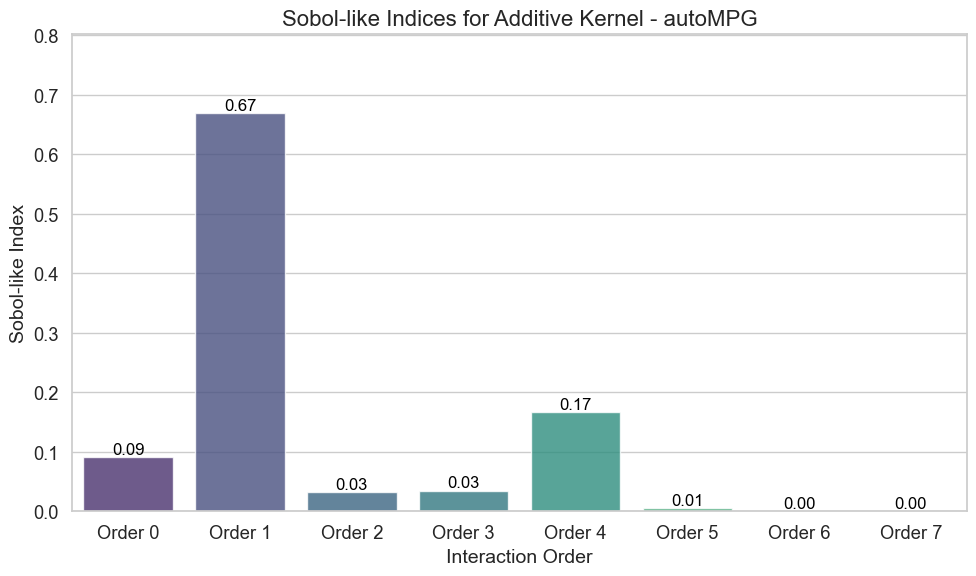

C:\Users\User\AppData\Local\Temp\ipykernel_23368\920899265.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Interaction Order', y='Sobol Index', data=df_sobol, palette='viridis', alpha=0.8)


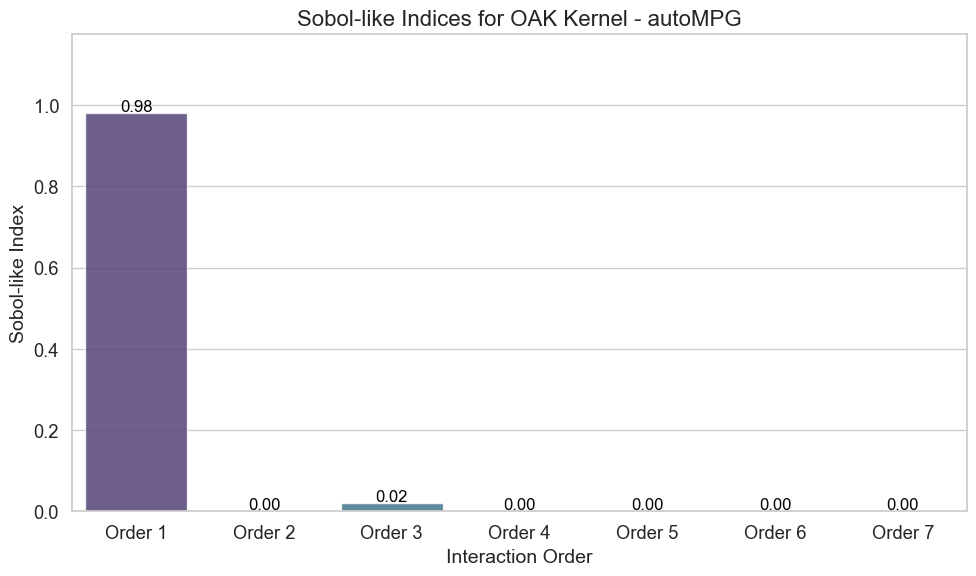

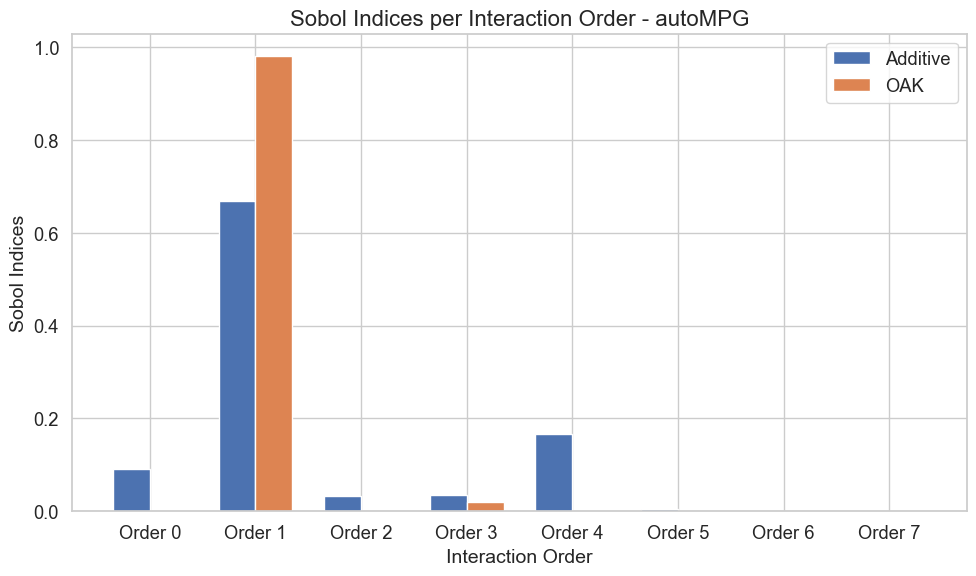

--------------------------------------------------


In [23]:
# Iterate over each dataset
for result, (dataset_name, feature_names) in zip(results, datasets.items()):
    print(f"Evaluating on Dataset: {dataset_name}\n")

    (
        additive_results,
        sobol_order_add,
        sobol_indices_add,
        oak_results,
        sobol_order_oak,
        sobol_indices_oak,
    ) = result

    # plotting additive and oak sobol indices (individual) figures
    plot_sobol_indices(sobol_indices_add, dataset_name, "Additive") 
    plot_sobol_indices(sobol_indices_oak, dataset_name, "OAK")

    # ----------------------------------
    # Plotting Aggregated Sobol Indices
    # ----------------------------------

    # TODO: assert len(feature_names) == len(sobol_order_add) == len(sobol_order_oak)

    # Create a bar chart aggregating Sobol indices per order for both kernels
    fig, ax = plt.subplots(figsize=(10, 6))
    orders = np.arange(len(feature_names) + 1)
    bar_width = 0.35  # bar width
    index = np.arange(len(orders))  # bar positions

    # Plot for Additive Kernel
    ax.bar(
        index - bar_width / 2, sobol_order_add, bar_width, label="Additive", color="C0"
    )

    # prepending a 0 to the sobol_order_oak to match the length of sobol_order_add (which means 0 contribution to the overall variance from the 0th order term)
    sobol_order_oak = np.insert(sobol_order_oak, 0, 0)

    # Plot for OAK Kernel
    ax.bar(index + bar_width / 2, sobol_order_oak, bar_width, label="OAK", color="C1")

    # plotting figures
    ax.set_xlabel("Interaction Order", fontsize=14)
    ax.set_ylabel("Sobol Indices", fontsize=14)
    ax.set_title(f"Sobol Indices per Interaction Order - {dataset_name}", fontsize=16)
    ax.set_xticks(index)
    ax.set_xticklabels([f"Order {r}" for r in orders])
    ax.legend()

    plt.tight_layout()

    # save the results plots in the `my_outputs` folder
    RESULTS_DIR = Path(".scratch.my_outputs")
    output_dir = RESULTS_DIR / dataset_name
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / f"{dataset_name}_sobol_indices.png")

    plt.show()

    # Save results dictionary as a JSON file
    with open(output_dir / f"{dataset_name}_results.json", "w") as f:
        # Convert numpy arrays to lists for JSON serialization
        results_dict = {
            "Additive": additive_results,
            "OAK": oak_results,
            "sobol_indices_add": sobol_indices_add,
            "sobol_indices_oak": sobol_indices_oak,
        }
        json.dump(results_dict, f, indent=4)

    # # -----------------
    # # Optional: Plot RMSE vs Cumulative Sobol Indices
    # # -----------------
    # # if want to plot RMSE against cumulative Sobol indices:

    # # Compute cumulative Sobol indices for Additive Kernel
    # cumulative_sobol_add = np.cumsum(sobol_order_add)

    # # Retrieve RMSE from cross-validation results (average over folds)
    # rmse_add_mean = np.mean(results["Additive"][dataset_name]["rmse"])
    # rmse_add_std = np.std(results["Additive"][dataset_name]["rmse"])

    # # Compute cumulative Sobol indices for OAK Kernel
    # cumulative_sobol_oak = np.cumsum(sobol_order_oak)

    # # Retrieve RMSE from cross-validation results (average over folds)
    # rmse_oak_mean = np.mean(results["OAK"][dataset_name]["rmse"])
    # rmse_oak_std = np.std(results["OAK"][dataset_name]["rmse"])

    # # Plot RMSE and Cumulative Sobol Indices for Additive Kernel
    # fig, ax1 = plt.subplots(figsize=(8, 4))

    # color = "tab:red"
    # ax1.set_xlabel("Number of Terms Added", fontsize=14)
    # ax1.set_ylabel("RMSE", color=color, fontsize=14)
    # ax1.errorbar(
    #     np.arange(len(cumulative_sobol_add)),
    #     [rmse_add_mean] * len(cumulative_sobol_add),
    #     yerr=[rmse_add_std] * len(cumulative_sobol_add),
    #     fmt="o-",
    #     color=color,
    #     label="RMSE Additive",
    # )
    # ax1.tick_params(axis="y", labelcolor=color)

    # ax2 = ax1.twinx()
    # color = "tab:green"
    # ax2.set_ylabel("Cumulative Sobol", color=color, fontsize=14)
    # ax2.plot(
    #     np.arange(len(cumulative_sobol_add)),
    #     cumulative_sobol_add,
    #     "-.g",
    #     linewidth=2,
    #     label="Cumulative Sobol Additive",
    # )
    # ax2.tick_params(axis="y", labelcolor=color)

    # plt.title(
    #     f"{dataset_name} - Additive Kernel RMSE and Cumulative Sobol", fontsize=16
    # )
    # fig.tight_layout()

    # # save the results plots in the `my_outputs` folder
    # plt.savefig(output_dir / f"{dataset_name}_rmse_cumulative_sobol_additive.png")

    # plt.show()

    # # Plot RMSE and Cumulative Sobol Indices for OAK Kernel
    # fig, ax1 = plt.subplots(figsize=(8, 4))

    # color = "tab:blue"
    # ax1.set_xlabel("Number of Terms Added", fontsize=14)
    # ax1.set_ylabel("RMSE", color=color, fontsize=14)
    # ax1.errorbar(
    #     np.arange(len(cumulative_sobol_oak)),
    #     [rmse_oak_mean] * len(cumulative_sobol_oak),
    #     yerr=[rmse_oak_std] * len(cumulative_sobol_oak),
    #     fmt="o-",
    #     color=color,
    #     label="RMSE OAK",
    # )
    # ax1.tick_params(axis="y", labelcolor=color)

    # ax2 = ax1.twinx()
    # color = "tab:red"
    # ax2.set_ylabel("Cumulative Sobol", color=color, fontsize=14)
    # ax2.plot(
    #     np.arange(len(cumulative_sobol_oak)),
    #     cumulative_sobol_oak,
    #     "-.m",
    #     linewidth=2,
    #     label="Cumulative Sobol OAK",
    # )
    # ax2.tick_params(axis="y", labelcolor=color)

    # plt.title(f"{dataset_name} - OAK Kernel RMSE and Cumulative Sobol", fontsize=16)
    # fig.tight_layout()

    # # save the results plots in the `my_outputs` folder
    # plt.savefig(output_dir / f"{dataset_name}_rmse_cumulative_sobol_oak.png")

    # plt.show()

    print("-" * 50)

In [71]:
# # Cell 8: Model Training and Evaluation Across Multiple Datasets - NO MULTITHREADING

# # Define the list of datasets you want to evaluate
# datasets = {
#     # 'autoMPG': [
#     #     "cylinders",
#     #     "displacement",
#     #     "horsepower",
#     #     "weight",
#     #     "acceleration",
#     #     "year",
#     #     "origin",
#     # ],
#     # 'synthetic_behaviour_type0': [
#     #     "x_1",
#     #     "x_2",
#     # ],
    
#     # 'synthetic_behaviour_type1': [
#     #     "x_1",
#     #     "x_2",
#     #     "x_3",
#     # ],
    
#     # 'synthetic_behaviour_type2': [
#     #     "x_1",
#     #     "x_2",
#     # ],
    
#     # 'synthetic_behaviour_type3': [
#     #     "x_1",
#     #     "x_2",
#     #     "x_3",
#     # ],
    
#     # 'synthetic_behaviour_type4': [
#     #     "x_1",
#     #     "x_2",
#     #     "x_3",
#     # ],
    
#     # 'synthetic_behaviour_type5': [
#     #     "x_1",
#     #     "x_2",
#     #     "x_3",
#     #     "x_4",
#     # ],
    
#     'synthetic_behaviour_type6': [
#         "x_1",
#         "x_2",
#         "x_3",
#         "x_4",
#         "x_5",
#         "x_6",
#         "x_7",
#         "x_8",
#         "x_9",
#         "x_10",
#     ],
    
#     # # Add more datasets as needed with their feature names
#     # 'anotherDataset': [
#     #     "feature1",
#     #     "feature2",
#     #     "feature3",
#     # ],
# }




# # Define the number of folds for CV
# k_folds = 5

# # Define the number of inducing points for sparse models
# num_inducing = 200  # Adjust based on dataset size and computational resources

# # Initialize dictionaries to store results
# results = {
#     'Additive': {},
#     'OAK': {}
# }

# # Iterate over each dataset
# for dataset_name, feature_names in datasets.items():
#     print(f"Evaluating on Dataset: {dataset_name}\n")
    
#     # Load the dataset
#     X, y = load_regression_dataset(dataset_name, DATA_PATH_PREFIX)
    
#     # Define the maximum interaction depth for the Additive Kernel
#     max_interaction_depth = X.shape[1]  # Adjust as needed
    
#     # -----------------
#     # Evaluate Additive Kernel
#     # -----------------
#     print("Additive Kernel:")
#     additive_results = perform_kfold_cv(
#         AdditiveGPModel,
#         X,
#         y,
#         k=k_folds,
#         compute_nll_func=compute_nll_add_model,
#         max_interaction_depth= max_interaction_depth,
#         share_var_across_orders=True,
#         num_inducing=num_inducing  # Adjust based on dataset size
#     )
#     results['Additive'][dataset_name] = additive_results
    
#     # Compute and plot Sobol-like indices for Additive Kernel on the entire dataset
#     add_full = AdditiveGPModel(
#         max_interaction_depth=max_interaction_depth, 
#         share_var_across_orders=True, 
#         num_inducing=num_inducing
#     )
#     add_full.fit(X, y)
#     sobol_indices_add = compute_sobol_indices_additive(add_full, X)
#     plot_sobol_indices(sobol_indices_add, dataset_name, 'Additive')
    
#     # Aggregate Sobol indices per order (starting from order 0)
#     sobol_order_add = np.zeros(max_interaction_depth +1)
#     for r in range(max_interaction_depth +1):
#         sobol_order_add[r] = sobol_indices_add.get(f'Order {r}', 0)
    
#     # -----------------
#     # Evaluate OAK Kernel
#     # -----------------
#     print("OAK Kernel:")
#     oak_results = perform_kfold_cv(
#         oak_model,
#         X,
#         y,
#         k=k_folds,
#         compute_nll_func=compute_nll_oak_model,
#         max_interaction_depth=max_interaction_depth,
#         share_var_across_orders=True,
#         num_inducing=num_inducing  # Adjust based on dataset size
#     )
#     results['OAK'][dataset_name] = oak_results
    
#     # Fit the OAK model on the entire dataset
#     oak_full = oak_model(
#         max_interaction_depth=max_interaction_depth,
#         share_var_across_orders=True,
#         num_inducing=num_inducing
#     )
#     oak_full.fit(X, y)
    
#     # Compute Sobol-like indices using the helper function
#     sobol_indices_oak = compute_sobol_indices_oak(oak_full, X, y)
    
#     # fixing plotting issue with mismatched labels
#     renamed_data = {f"Order {int(k.split()[1]) + 1}": v for k, v in sobol_indices_oak.items()}
#     renamed_data.popitem()
#     sobol_indices_oak = renamed_data

#     # Aggregate Sobol indices per order (starting from order 0)
#     sobol_order_oak = np.zeros(max_interaction_depth)
#     for r in range(1, max_interaction_depth +1):
#         sobol_order_oak[r-1] = sobol_indices_oak.get(f'Order {r}', 0)
    
#     # Plot Sobol-like indices for OAK Kernel
#     plot_sobol_indices(sobol_indices_oak, dataset_name, 'OAK')


    
#     # ----------------------------------
#     # Plotting Aggregated Sobol Indices
#     # ----------------------------------

#     # Create a bar chart aggregating Sobol indices per order for both kernels
#     fig, ax = plt.subplots(figsize=(10,6))
#     orders = np.arange(max_interaction_depth +1)    
#     bar_width = 0.35 # bar width    
#     index = np.arange(len(orders)) # bar positions
    
#     # Plot for Additive Kernel
#     ax.bar(index - bar_width/2, sobol_order_add, bar_width, label='Additive', color='C0')
    
#     # prepending a 0 to the sobol_order_oak to match the length of sobol_order_add (which means 0 contribution to the overall variance from the 0th order term)
#     sobol_order_oak = np.insert(sobol_order_oak, 0, 0)

#     # Plot for OAK Kernel
#     ax.bar(index + bar_width/2, sobol_order_oak, bar_width, label='OAK', color='C1')
    
#     # plotting figures
#     ax.set_xlabel('Interaction Order', fontsize=14)
#     ax.set_ylabel('Sobol Indices', fontsize=14)
#     ax.set_title(f'Sobol Indices per Interaction Order - {dataset_name}', fontsize=16)
#     ax.set_xticks(index)
#     ax.set_xticklabels([f'Order {r}' for r in orders])
#     ax.legend()
    
#     plt.tight_layout()

#     # save the results plots in the `my_outputs` folder
#     output_dir = Path('.scratch.my_outputs') / dataset_name
#     output_dir.mkdir(parents=True, exist_ok=True)
#     plt.savefig(output_dir/ f"{dataset_name}_sobol_indices.png")

#     plt.show()

    
    
#     # # -----------------
#     # # Optional: Plot RMSE vs Cumulative Sobol Indices
#     # # -----------------
#     # # if want to plot RMSE against cumulative Sobol indices:
    
#     # # Compute cumulative Sobol indices for Additive Kernel
#     # cumulative_sobol_add = np.cumsum(sobol_order_add)
    
#     # # Retrieve RMSE from cross-validation results (average over folds)
#     # rmse_add_mean = np.mean(results['Additive'][dataset_name]['rmse'])
#     # rmse_add_std = np.std(results['Additive'][dataset_name]['rmse'])
    
#     # # Compute cumulative Sobol indices for OAK Kernel
#     # cumulative_sobol_oak = np.cumsum(sobol_order_oak)
    
#     # # Retrieve RMSE from cross-validation results (average over folds)
#     # rmse_oak_mean = np.mean(results['OAK'][dataset_name]['rmse'])
#     # rmse_oak_std = np.std(results['OAK'][dataset_name]['rmse'])
    
#     # # Plot RMSE and Cumulative Sobol Indices for Additive Kernel
#     # fig, ax1 = plt.subplots(figsize=(8, 4))
    
#     # color = 'tab:red'
#     # ax1.set_xlabel("Number of Terms Added", fontsize=14)
#     # ax1.set_ylabel("RMSE", color=color, fontsize=14)
#     # ax1.errorbar(np.arange(len(cumulative_sobol_add)), 
#     #              [rmse_add_mean]*len(cumulative_sobol_add), 
#     #              yerr=[rmse_add_std]*len(cumulative_sobol_add), 
#     #              fmt='o-', color=color, label='RMSE Additive')
#     # ax1.tick_params(axis='y', labelcolor=color)
    
#     # ax2 = ax1.twinx()
#     # color = 'tab:green'
#     # ax2.set_ylabel("Cumulative Sobol", color=color, fontsize=14)
#     # ax2.plot(np.arange(len(cumulative_sobol_add)), cumulative_sobol_add, '-.g', linewidth=2, label='Cumulative Sobol Additive')
#     # ax2.tick_params(axis='y', labelcolor=color)
    
#     # plt.title(f'{dataset_name} - Additive Kernel RMSE and Cumulative Sobol', fontsize=16)
#     # fig.tight_layout()
    
#     # # save the results plots in the `my_outputs` folder
#     # plt.savefig(f"my_outputs/{dataset_name}/{dataset_name}_rmse_cumulative_sobol_additive.png")

#     # plt.show()


#     # # Plot RMSE and Cumulative Sobol Indices for OAK Kernel
#     # fig, ax1 = plt.subplots(figsize=(8, 4))
    
#     # color = 'tab:blue'
#     # ax1.set_xlabel("Number of Terms Added", fontsize=14)
#     # ax1.set_ylabel("RMSE", color=color, fontsize=14)
#     # ax1.errorbar(np.arange(len(cumulative_sobol_oak)), 
#     #              [rmse_oak_mean]*len(cumulative_sobol_oak), 
#     #              yerr=[rmse_oak_std]*len(cumulative_sobol_oak), 
#     #              fmt='o-', color=color, label='RMSE OAK')
#     # ax1.tick_params(axis='y', labelcolor=color)
    
#     # ax2 = ax1.twinx()
#     # color = 'tab:red'
#     # ax2.set_ylabel("Cumulative Sobol", color=color, fontsize=14)
#     # ax2.plot(np.arange(len(cumulative_sobol_oak)), cumulative_sobol_oak, '-.m', linewidth=2, label='Cumulative Sobol OAK')
#     # ax2.tick_params(axis='y', labelcolor=color)
    
#     # plt.title(f'{dataset_name} - OAK Kernel RMSE and Cumulative Sobol', fontsize=16)
#     # fig.tight_layout()

#     # # save the results plots in the `my_outputs` folder
#     # plt.savefig(f"my_outputs/{dataset_name}/{dataset_name}_rmse_cumulative_sobol_oak.png")
    
#     # plt.show()
    
#     print("-" * 50)


In [24]:
results_dict

{'Additive': {'rmse': [2.2635765316080327,
   3.2797525779897754,
   2.2674975776553836,
   2.682291503567523,
   2.43483494820358],
  'nll': [0.15557328680108515,
   0.7350172258849277,
   0.20744695900448845,
   0.3609494877378785,
   0.2520777584505977]},
 'OAK': {'rmse': [2.18718840428938,
   3.194082235776969,
   2.4886971240024853,
   nan,
   nan],
  'nll': [0.11046566285623396,
   0.6790032360463518,
   0.23797498908210926,
   0.5596867648657179,
   0.14811231246929166]},
 'sobol_indices_add': {'Order 0': 0.09131798878991682,
  'Order 1': 0.6690393705017508,
  'Order 2': 0.03178899278096493,
  'Order 3': 0.03472164780519111,
  'Order 4': 0.16716668378371227,
  'Order 5': 0.005867176637635633,
  'Order 6': 9.714715447252515e-05,
  'Order 7': 9.925463559782233e-07},
 'sobol_indices_oak': {'Order 1': 0.9799660078322504,
  'Order 2': 2.9923891642181263e-16,
  'Order 3': 0.01997930002938452,
  'Order 4': 5.4692138363834385e-05,
  'Order 5': 8.813033093834198e-16,
  'Order 6': 2.07021

C:\Users\User\AppData\Local\Temp\ipykernel_23368\1026565295.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Dataset', y=metric.capitalize(), hue='Kernel', data=df, palette='deep', ci='sd')


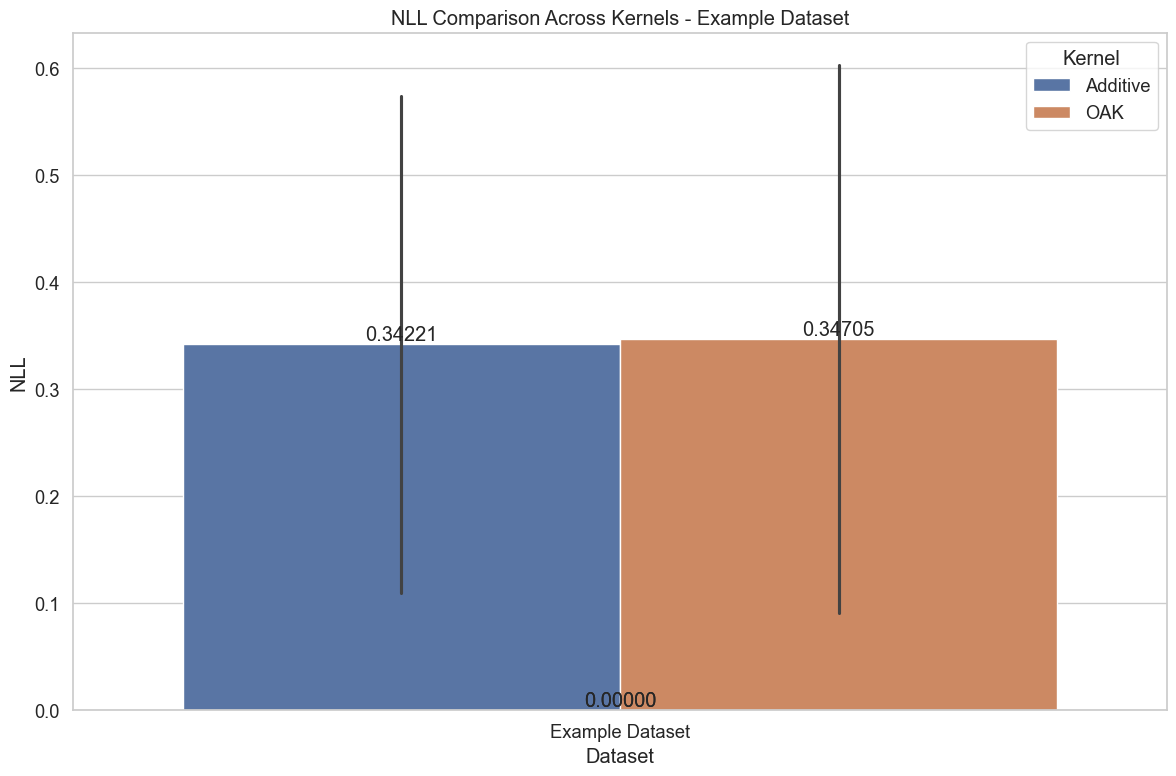

C:\Users\User\AppData\Local\Temp\ipykernel_23368\1026565295.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='Dataset', y=metric.capitalize(), hue='Kernel', data=df, palette='deep', ci='sd')


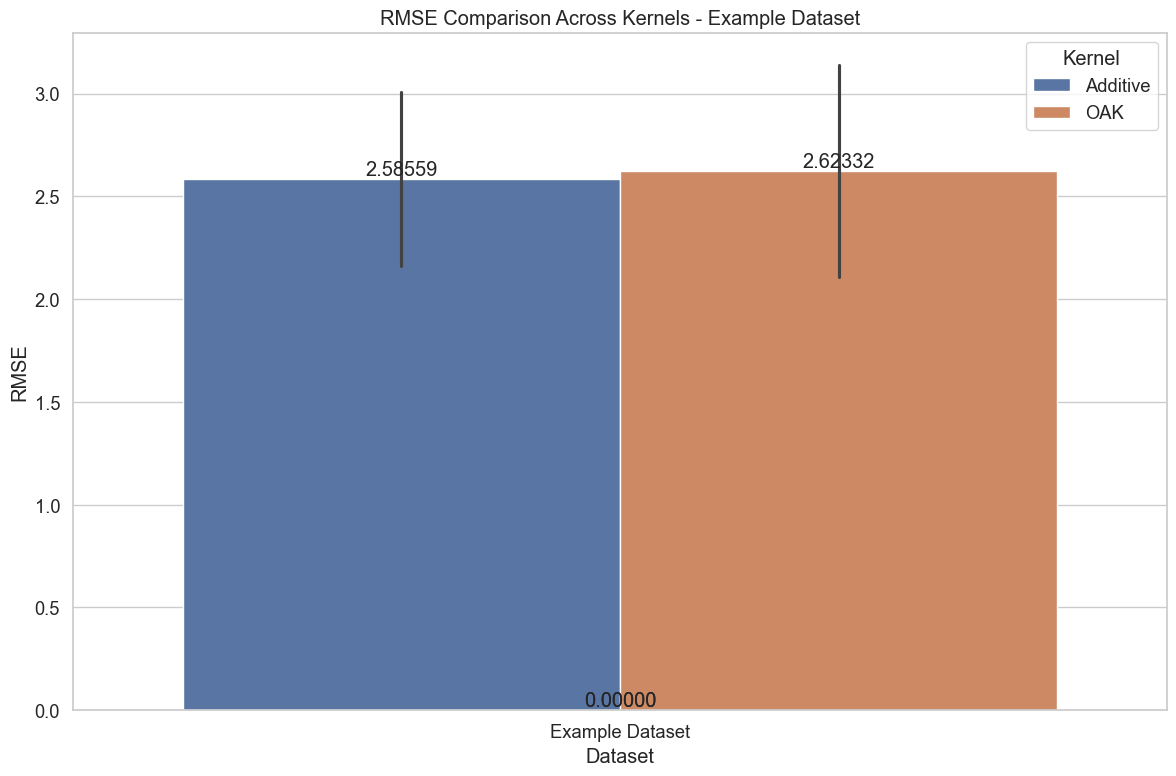

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_metrics_comparison(results_dict: dict, metric: str, dataset_name: str, kernel_types: list):
    """
    Plot a comparison of a specified metric (RMSE or NLL) across different kernels for a single dataset.

    :param results_dict: Dictionary containing results (one dataset, multiple kernels).
    :param metric: Metric to plot ('rmse' or 'nll').
    :param dataset_name: Name of the dataset (for plot titles/labels).
    :param kernel_types: List of kernel types (e.g., ['Additive', 'OAK']).
    """
    # Prepare data for plotting
    data = []
    
    for kernel in kernel_types:
        metric_values = results_dict[kernel][metric]
        for fold, value in enumerate(metric_values):
            data.append({
                'Kernel': kernel,
                'Dataset': dataset_name,
                'Fold': f'Fold {fold + 1}',
                metric.capitalize(): float(value)  # Make sure it's a float for plotting
            })
    
    df = pd.DataFrame(data)
    
    # Plot
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Dataset', y=metric.capitalize(), hue='Kernel', data=df, palette='deep', ci='sd')

    # Add numerical labels
    for p in plt.gca().patches:
        height = p.get_height()
        if not np.isnan(height):  # Avoid label placement on empty bars
            plt.gca().text(
                p.get_x() + p.get_width() / 2.,
                height + 0.0001,
                f'{height:.5f}',
                ha='center',
                va='bottom'
            )
    
    plt.title(f'{metric.upper()} Comparison Across Kernels - {dataset_name}')
    plt.xlabel('Dataset')
    plt.ylabel(metric.upper())
    plt.legend(title='Kernel')
    plt.tight_layout()

    # Optionally save the plot (adjust the output directory to your needs)
    # plt.savefig(f"{metric}_comparison_{dataset_name}.png")

    plt.show()

# Example usage
kernel_types = ['Additive', 'OAK']
dataset_name = 'Example Dataset'

# Plot NLL
plot_metrics_comparison(results_dict, 'nll', dataset_name, kernel_types)

# Plot RMSE
plot_metrics_comparison(results_dict, 'rmse', dataset_name, kernel_types)


In [74]:
#TODO need to update plotting for metrics according to new optimised functions

In [29]:
# Cell 9: Plotting Performance Metrics

def plot_metrics_comparison(results: dict, metric: str, dataset_names: list, kernel_types: list):
    """
    Plot a comparison of a specified metric (RMSE or NLL) across different kernels and datasets.

    :param results: Dictionary containing results.
    :param metric: Metric to plot ('rmse' or 'nll').
    :param dataset_names: List of dataset names.
    :param kernel_types: List of kernel types (e.g., ['Additive', 'OAK']).
    """
    # Prepare data for plotting
    data = []
    for kernel in kernel_types:
        for dataset in dataset_names:
            metric_values = results[kernel][dataset][metric]
            for fold, value in enumerate(metric_values):
                data.append({
                    'Kernel': kernel,
                    'Dataset': dataset,
                    'Fold': f'Fold {fold + 1}',
                    metric.capitalize(): value
                })
    
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Dataset', y=metric.capitalize(), hue='Kernel', data=df, palette='deep', ci='sd')
    
    # Add numerical labels
    for p in plt.gca().patches:
        height = p.get_height()
        plt.gca().text(
            p.get_x() + p.get_width() / 2., 
            height + 0.05, 
            f'{height:.2f}', 
            ha='center', 
            va='bottom', 
            fontsize=10
        )
    
    plt.title(f'{metric.upper()} Comparison Across Kernels and Datasets', fontsize=16)
    plt.xlabel('Dataset', fontsize=14)
    plt.ylabel(metric.upper(), fontsize=14)
    plt.legend(title='Kernel')
    plt.tight_layout()

    # save the results plots in the `my_outputs` folder
    plt.savefig(output_dir / f"{metric}_comparison.png")

    plt.show()

# Example usage after cross-validation:
dataset_names = list(datasets.keys())
kernel_types = ['Additive', 'OAK']

# Plot NLL
plot_metrics_comparison(results, 'nll', dataset_names, kernel_types)

# Plot RMSE
plot_metrics_comparison(results, 'rmse', dataset_names, kernel_types)




TypeError: list indices must be integers or slices, not str

In [30]:
# getting the marginal likelihood for oak vs additive
# Calculate and compare marginal likelihoods by taking avergaes of the likelihood from results

# Initialize dictionaries to store marginal likelihoods
marginal_likelihoods = {
    'Additive': {},
    'OAK': {}
}


print(f"\nDataset: {dataset_name}")
print("-" * 20)

oak_nlls = (results['OAK'][dataset_name]['nll'])
add_nlls = (results['Additive'][dataset_name]['nll'])

# Calculate mean NLL (negative log likelihood)
oak_mean_nll = np.nanmean(oak_nlls)
add_mean_nll = np.nanmean(add_nlls)

# Store results
marginal_likelihoods['OAK'][dataset_name] = oak_mean_nll
marginal_likelihoods['Additive'][dataset_name] = add_mean_nll

print(f"OAK mean NLL: {oak_mean_nll:.4f}")
print(f"Additive mean NLL: {add_mean_nll:.4f}")
print(f"Difference (OAK - Additive): {oak_mean_nll - add_mean_nll:.4f}")




Dataset: Example Dataset
--------------------


TypeError: list indices must be integers or slices, not str